In [67]:
import re
import string
import collections
import tensorflow as tf
import numpy as np
import nltk
import time
from collections import Counter,defaultdict
from scipy.sparse import coo_matrix
from scipy.sparse import load_npz




In [68]:
#test accuracy
def test_accuracy(Y_test,prediction_te):
    count=0
    for i in range(prediction_te[0].shape[0]):
        #print(prediction[0][i])
        if(Y_test[i][prediction_te[0][i]]==1):
            count=count+1
    return count/np.float(prediction_te[0].shape[0])

In [69]:
#training accuracy
def train_accuracy(Y_train,prediction_tr):
    count=0
    for i in range(len(prediction_tr)):
        if(Y_train[i][prediction_tr[i]]>0):
            count=count+1
    return count/np.float(len(prediction_tr))

In [70]:
X_train=load_npz('X_train_sparse.npz');
X_testthree_w_1[i]=load_npz('X_test_sparse.npz');
Y_train=np.load('Y_train.npy');
Y_test=np.load('Y_test.npy')

In [72]:
#with regularization and constant learning rate

reg_constant =0.001
initializer = tf.contrib.layers.xavier_initializer()
regularizer = tf.contrib.layers.l2_regularizer(scale = reg_constant) 
num_epochs = 100
batch_size = 5000
num_batches_per_epoch=int(X_train.shape[0]/batch_size)
num_batches_per_epoch_test=int(X_test.shape[0]/batch_size)
num_examples_test=X_test.shape[0]
num_examples=X_train.shape[0]
num_features=X_train.shape[1]
num_classes=Y_train.shape[1]

graph = tf.Graph()
with graph.as_default():
   
    inputs = tf.placeholder(shape=[None, num_features],dtype=tf.float32)
    outputs= tf.placeholder(shape=[None, num_classes],dtype=tf.float32)
    
    W=tf.get_variable(name = "W", shape = [num_features,num_classes],initializer=initializer,regularizer=regularizer) 
    b=tf.get_variable(name = "b", shape = [num_classes],initializer=initializer)
    logits = tf.add(tf.matmul(inputs, W),b)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=outputs))


    logits_pr=tf.nn.softmax(logits)
    pred=tf.argmax(logits,axis=1)
    
    #regularization losses
    reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    
    # final loss and optimization
    final_cost=cost+reg_constant*sum(reg_losses)
    optimizer = tf.train.AdamOptimizer(learning_rate=0.002).minimize(final_cost) 
test_acc_c=[]
loss_constant_lr=[]
with tf.Session(graph=graph) as session:

    tf.global_variables_initializer().run()
    begin=time.time()
    #iterating over total number of epochs
    for curr_epoch in range(num_epochs):
        start=time.time()
        train_cost=0
        for batch in range(num_batches_per_epoch):

            # Getting the index
            indexes = [i % num_examples for i in range(batch * batch_size, (batch + 1) * batch_size)]
            batch_train_inputs = X_train.tocsr()[indexes].toarray()
            batch_train_targets= Y_train[indexes]
            # feed dictionay for training
            feed = {inputs: batch_train_inputs,
                    outputs: batch_train_targets
                    }
           
            batch_cost, _ = session.run([final_cost, optimizer], feed)
            train_cost += batch_cost*batch_size
    
        log = "Epoch {}/{}, train_cost = {:.3f}, test_accuracy = {:.3f}, epoch time = {:.3f}s, total time = {:.3f}s"
        
        loss_constant_lr.append(train_cost/(num_batches_per_epoch*batch_size))
        
        test_inputs = X_test.tocsr().toarray()
        feed = {inputs: test_inputs}
        prediction_te = session.run([pred], feed)
        acc=test_accuracy(Y_test,prediction_te)
        test_acc_c.append(acc)
        print(log.format(curr_epoch+1, num_epochs, train_cost/(num_batches_per_epoch*batch_size),acc,time.time()-start,time.time()-begin))

    prediction_tr=[]
    for batch in range(num_batches_per_epoch):
                                                                   
        # Getting the index
        indexes = [i % num_examples for i in range(batch * batch_size, (batch + 1) * batch_size)]
        batch_train_inputs = X_train.tocsr()[indexes].toarray()
        feed = {inputs: batch_train_inputs}
        prediction = session.run([pred], feed)
        prediction_tr.extend(list(prediction[0]))
    test_inputs = X_test.tocsr().toarray()
    feed = {inputs: test_inputs}
    prediction_te = session.run([pred], feed)
    

Epoch 1/100, train_cost = 3.521, test_accuracy = 0.447, epoch time = 15.522s, total time = 15.522s
Epoch 2/100, train_cost = 2.887, test_accuracy = 0.600, epoch time = 16.183s, total time = 31.705s
Epoch 3/100, train_cost = 2.515, test_accuracy = 0.663, epoch time = 15.556s, total time = 47.261s
Epoch 4/100, train_cost = 2.262, test_accuracy = 0.723, epoch time = 14.951s, total time = 62.212s
Epoch 5/100, train_cost = 2.074, test_accuracy = 0.746, epoch time = 14.945s, total time = 77.157s
Epoch 6/100, train_cost = 1.927, test_accuracy = 0.770, epoch time = 15.636s, total time = 92.793s
Epoch 7/100, train_cost = 1.808, test_accuracy = 0.794, epoch time = 15.253s, total time = 108.047s
Epoch 8/100, train_cost = 1.709, test_accuracy = 0.804, epoch time = 14.489s, total time = 122.536s
Epoch 9/100, train_cost = 1.625, test_accuracy = 0.812, epoch time = 14.659s, total time = 137.195s
Epoch 10/100, train_cost = 1.553, test_accuracy = 0.817, epoch time = 15.103s, total time = 152.298s
Epoch

Epoch 83/100, train_cost = 0.768, test_accuracy = 0.835, epoch time = 14.331s, total time = 1237.125s
Epoch 84/100, train_cost = 0.767, test_accuracy = 0.835, epoch time = 14.096s, total time = 1251.221s
Epoch 85/100, train_cost = 0.765, test_accuracy = 0.835, epoch time = 14.499s, total time = 1265.720s
Epoch 86/100, train_cost = 0.764, test_accuracy = 0.835, epoch time = 14.439s, total time = 1280.159s
Epoch 87/100, train_cost = 0.762, test_accuracy = 0.835, epoch time = 14.620s, total time = 1294.779s
Epoch 88/100, train_cost = 0.761, test_accuracy = 0.835, epoch time = 14.316s, total time = 1309.096s
Epoch 89/100, train_cost = 0.760, test_accuracy = 0.835, epoch time = 14.319s, total time = 1323.414s
Epoch 90/100, train_cost = 0.758, test_accuracy = 0.835, epoch time = 14.777s, total time = 1338.192s
Epoch 91/100, train_cost = 0.757, test_accuracy = 0.834, epoch time = 15.199s, total time = 1353.391s
Epoch 92/100, train_cost = 0.756, test_accuracy = 0.834, epoch time = 14.559s, tot

In [73]:
tr_acc=train_accuracy(Y_train,prediction_tr)
print("accuracy on training data with constant learning rate is ",tr_acc)
te_acc=test_accuracy(Y_test,prediction_te)
print("accuracy on test data with constant learning rate is ",te_acc)

accuracy on training data with constant learning rate is  0.9096095238095238
accuracy on test data with constant learning rate is  0.8336833683368337


In [74]:
#exponential decay

reg_constant =0.001
initializer = tf.contrib.layers.xavier_initializer()
regularizer = tf.contrib.layers.l2_regularizer(scale = reg_constant) 
num_epochs = 100
batch_size = 5000
num_batches_per_epoch=int(X_train.shape[0]/batch_size)
num_batches_per_epoch_test=int(X_test.shape[0]/batch_size)
num_examples_test=X_test.shape[0]
num_examples=X_train.shape[0]
num_features=X_train.shape[1]
num_classes=Y_train.shape[1]

graph = tf.Graph()
with graph.as_default():
    starter_learning_rate = 0.002
    global_step = tf.get_variable('global_step', [],initializer = tf.constant_initializer(0),trainable = False)
    inputs = tf.placeholder(shape=[None, num_features],dtype=tf.float32)
    outputs= tf.placeholder(shape=[None, num_classes],dtype=tf.float32)
    
    W=tf.get_variable(name = "W", shape = [num_features,num_classes],initializer=initializer,regularizer=regularizer) 
    b=tf.get_variable(name = "b", shape = [num_classes],initializer=initializer)
    logits = tf.add(tf.matmul(inputs, W),b)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=outputs))


    logits_pr=tf.nn.softmax(logits)
    pred=tf.argmax(logits,axis=1)
    
    #regularization losses
    reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    
    # final loss and optimization
    final_cost=cost+reg_constant*sum(reg_losses)
    lr= tf.train.exponential_decay(starter_learning_rate, global_step,
                                           num_batches_per_epoch, 0.96, staircase=True)
    optimizer = tf.train.AdamOptimizer(learning_rate=lr).minimize(final_cost,global_step=global_step) 
test_acc_d=[]
loss_decay_lr=[]
with tf.Session(graph=graph) as session:

    tf.global_variables_initializer().run()
    begin=time.time()
    #iterating over total number of epochs
    for curr_epoch in range(num_epochs):
        train_cost=0
        start = time.time()
        for batch in range(num_batches_per_epoch):

            # Getting the index
            indexes = [i % num_examples for i in range(batch * batch_size, (batch + 1) * batch_size)]
            batch_train_inputs = X_train.tocsr()[indexes].toarray()
            batch_train_targets= Y_train[indexes]
            # feed dictionay for training
            feed = {inputs: batch_train_inputs,
                    outputs: batch_train_targets
                    }
           
            batch_cost, _ = session.run([final_cost, optimizer], feed)
            train_cost += batch_cost*batch_size
        log = "Epoch {}/{}, train_cost = {:.3f}, test_accuracy = {:.3f}, epoch time = {:.3f}s, total time = {:.3f}s"
        loss_decay_lr.append(train_cost/(num_batches_per_epoch*batch_size))
        test_inputs = X_test.tocsr().toarray()
        feed = {inputs: test_inputs}
        prediction_te = session.run([pred], feed)
        acc=test_accuracy(Y_test,prediction_te)
        test_acc_d.append(acc)
        print(log.format(curr_epoch+1, num_epochs, train_cost/(num_batches_per_epoch*batch_size),acc,time.time()-start,time.time()-begin))

    prediction_tr=[]
    for batch in range(num_batches_per_epoch):
                                                                   
        # Getting the index
        indexes = [i % num_examples for i in range(batch * batch_size, (batch + 1) * batch_size)]
        batch_train_inputs = X_train.tocsr()[indexes].toarray()
        feed = {inputs: batch_train_inputs}
        prediction = session.run([pred], feed)
        prediction_tr.extend(list(prediction[0]))
    test_inputs = X_test.tocsr().toarray()
    feed = {inputs: test_inputs}
    prediction_te = session.run([pred], feed)
    

Epoch 1/100, train_cost = 3.519, test_accuracy = 0.374, epoch time = 16.617s, total time = 16.617s
Epoch 2/100, train_cost = 2.891, test_accuracy = 0.564, epoch time = 16.595s, total time = 33.212s
Epoch 3/100, train_cost = 2.534, test_accuracy = 0.627, epoch time = 16.187s, total time = 49.399s
Epoch 4/100, train_cost = 2.296, test_accuracy = 0.674, epoch time = 15.886s, total time = 65.301s
Epoch 5/100, train_cost = 2.122, test_accuracy = 0.718, epoch time = 16.269s, total time = 81.570s
Epoch 6/100, train_cost = 1.988, test_accuracy = 0.748, epoch time = 15.545s, total time = 97.115s
Epoch 7/100, train_cost = 1.881, test_accuracy = 0.769, epoch time = 15.989s, total time = 113.104s
Epoch 8/100, train_cost = 1.793, test_accuracy = 0.783, epoch time = 15.914s, total time = 129.019s
Epoch 9/100, train_cost = 1.719, test_accuracy = 0.801, epoch time = 15.794s, total time = 144.813s
Epoch 10/100, train_cost = 1.656, test_accuracy = 0.808, epoch time = 16.052s, total time = 160.865s
Epoch

Epoch 83/100, train_cost = 1.023, test_accuracy = 0.838, epoch time = 15.971s, total time = 1326.994s
Epoch 84/100, train_cost = 1.022, test_accuracy = 0.838, epoch time = 15.869s, total time = 1342.863s
Epoch 85/100, train_cost = 1.021, test_accuracy = 0.838, epoch time = 16.116s, total time = 1358.979s
Epoch 86/100, train_cost = 1.021, test_accuracy = 0.838, epoch time = 16.216s, total time = 1375.195s
Epoch 87/100, train_cost = 1.020, test_accuracy = 0.838, epoch time = 16.195s, total time = 1391.391s
Epoch 88/100, train_cost = 1.019, test_accuracy = 0.838, epoch time = 15.993s, total time = 1407.384s
Epoch 89/100, train_cost = 1.019, test_accuracy = 0.838, epoch time = 16.307s, total time = 1423.691s
Epoch 90/100, train_cost = 1.018, test_accuracy = 0.838, epoch time = 16.066s, total time = 1439.757s
Epoch 91/100, train_cost = 1.018, test_accuracy = 0.838, epoch time = 15.969s, total time = 1455.726s
Epoch 92/100, train_cost = 1.017, test_accuracy = 0.838, epoch time = 15.998s, tot

In [75]:
tr_acc=train_accuracy(Y_train,prediction_tr)
print("accuracy on training data with exponential decay learning rate is ",tr_acc*100.0,"%")
te_acc=test_accuracy(Y_test,prediction_te)
print("accuracy on test data with exponential decay learning rate is ",te_acc*100.0,"%")

accuracy on training data with exponential decay learning rate is  86.88047619047619 %
accuracy on test data with exponential decay learning rate is  83.7917125045838 %


In [76]:
#exponential increase
reg_constant =0.001
initializer = tf.contrib.layers.xavier_initializer()
regularizer = tf.contrib.layers.l2_regularizer(scale = reg_constant) 
num_epochs = 100
batch_size = 5000
num_batches_per_epoch=int(X_train.shape[0]/batch_size)
num_batches_per_epoch_test=int(X_test.shape[0]/batch_size)
num_examples_test=X_test.shape[0]
num_examples=X_train.shape[0]
num_features=X_train.shape[1]
num_classes=Y_train.shape[1]

graph = tf.Graph()
with graph.as_default():
    starter_learning_rate = 0.002
    global_step = tf.get_variable('global_step', [],initializer = tf.constant_initializer(0),trainable = False)
    inputs = tf.placeholder(shape=[None, num_features],dtype=tf.float32)
    outputs= tf.placeholder(shape=[None, num_classes],dtype=tf.float32)
    
    W=tf.get_variable(name = "W", shape = [num_features,num_classes],initializer=initializer,regularizer=regularizer) 
    b=tf.get_variable(name = "b", shape = [num_classes],initializer=initializer)
    logits = tf.add(tf.matmul(inputs, W),b)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=outputs))


    logits_pr=tf.nn.softmax(logits)
    pred=tf.argmax(logits,axis=1)
    
    #regularization losses
    reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    
    # final loss and optimization
    final_cost=cost+reg_constant*sum(reg_losses)
    lr= tf.train.exponential_decay(starter_learning_rate, global_step,
                                           num_batches_per_epoch, 1.04, staircase=True)
    optimizer = tf.train.AdamOptimizer(learning_rate=lr).minimize(final_cost,global_step=global_step) 
test_acc_i=[]
loss_increasing_lr=[]
with tf.Session(graph=graph) as session:

    tf.global_variables_initializer().run()
    begin=time.time()
    #iterating over total number of epochs
    for curr_epoch in range(num_epochs):
        train_cost=0
        start = time.time()
        for batch in range(num_batches_per_epoch):

            # Getting the index
            indexes = [i % num_examples for i in range(batch * batch_size, (batch + 1) * batch_size)]
            batch_train_inputs = X_train.tocsr()[indexes].toarray()
            batch_train_targets= Y_train[indexes]
            # feed dictionay for training
            feed = {inputs: batch_train_inputs,
                    outputs: batch_train_targets
                    }
           
            batch_cost, _ = session.run([final_cost, optimizer], feed)
            train_cost += batch_cost*batch_size
        log = "Epoch {}/{}, train_cost = {:.3f}, test_accuracy = {:.3f}, epoch time = {:.3f}s, total time = {:.3f}s"
        loss_increasing_lr.append(train_cost/(num_batches_per_epoch*batch_size))
        test_inputs = X_test.tocsr().toarray()
        feed = {inputs: test_inputs}
        prediction_te = session.run([pred], feed)
        acc=test_accuracy(Y_test,prediction_te)
        test_acc_i.append(acc)
        print(log.format(curr_epoch+1, num_epochs, train_cost/(num_batches_per_epoch*batch_size),acc,time.time()-start,time.time()-begin))

    prediction_tr=[]
    for batch in range(num_batches_per_epoch):
                                                                   
        # Getting the index
        indexes = [i % num_examples for i in range(batch * batch_size, (batch + 1) * batch_size)]
        batch_train_inputs = X_train.tocsr()[indexes].toarray()
        feed = {inputs: batch_train_inputs}
        prediction = session.run([pred], feed)
        prediction_tr.extend(list(prediction[0]))
    test_inputs = X_test.tocsr().toarray()
    feed = {inputs: test_inputs}
    prediction_te = session.run([pred], feed)
    

Epoch 1/100, train_cost = 3.516, test_accuracy = 0.460, epoch time = 15.628s, total time = 15.628s
Epoch 2/100, train_cost = 2.874, test_accuracy = 0.606, epoch time = 15.504s, total time = 31.131s
Epoch 3/100, train_cost = 2.489, test_accuracy = 0.644, epoch time = 16.146s, total time = 47.277s
Epoch 4/100, train_cost = 2.223, test_accuracy = 0.665, epoch time = 16.260s, total time = 63.538s
Epoch 5/100, train_cost = 2.022, test_accuracy = 0.699, epoch time = 16.058s, total time = 79.597s
Epoch 6/100, train_cost = 1.863, test_accuracy = 0.750, epoch time = 15.612s, total time = 95.209s
Epoch 7/100, train_cost = 1.734, test_accuracy = 0.775, epoch time = 16.609s, total time = 111.819s
Epoch 8/100, train_cost = 1.625, test_accuracy = 0.804, epoch time = 15.289s, total time = 127.108s
Epoch 9/100, train_cost = 1.532, test_accuracy = 0.815, epoch time = 16.414s, total time = 143.523s
Epoch 10/100, train_cost = 1.451, test_accuracy = 0.822, epoch time = 15.676s, total time = 159.199s
Epoch

Epoch 83/100, train_cost = 0.906, test_accuracy = 0.819, epoch time = 15.487s, total time = 1290.956s
Epoch 84/100, train_cost = 0.916, test_accuracy = 0.826, epoch time = 15.353s, total time = 1306.309s
Epoch 85/100, train_cost = 0.929, test_accuracy = 0.826, epoch time = 15.654s, total time = 1321.964s
Epoch 86/100, train_cost = 0.943, test_accuracy = 0.819, epoch time = 15.552s, total time = 1337.516s
Epoch 87/100, train_cost = 0.970, test_accuracy = 0.815, epoch time = 15.163s, total time = 1352.680s
Epoch 88/100, train_cost = 0.998, test_accuracy = 0.831, epoch time = 15.225s, total time = 1367.905s
Epoch 89/100, train_cost = 1.026, test_accuracy = 0.820, epoch time = 15.396s, total time = 1383.302s
Epoch 90/100, train_cost = 1.027, test_accuracy = 0.812, epoch time = 15.123s, total time = 1398.425s
Epoch 91/100, train_cost = 1.025, test_accuracy = 0.818, epoch time = 15.089s, total time = 1413.514s
Epoch 92/100, train_cost = 1.042, test_accuracy = 0.827, epoch time = 15.252s, tot

In [77]:
tr_acc=train_accuracy(Y_train,prediction_tr)
print("accuracy on training data with exponential increasing learning rate is ",tr_acc*100,"%")
te_acc=test_accuracy(Y_test,prediction_te)
print("accuracy on test data with exponential increasing learning rate is ",te_acc*100,"%")

accuracy on training data with exponential increasing learning rate is  85.79285714285714 %
accuracy on test data with exponential increasing learning rate is  81.36146948028136 %


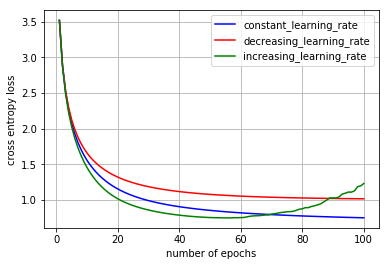

In [79]:
import matplotlib.pyplot as plt

x=[i for i in range(1,101)]
plt.plot(x,loss_constant_lr , 'b', label='constant_learning_rate')
plt.plot(x,loss_decay_lr, 'r', label='decreasing_learning_rate')
plt.plot(x, loss_increasing_lr, 'g', label='increasing_learning_rate')
plt.ylabel('cross entropy loss')
plt.xlabel('number of epochs')
plt.grid()
plt.legend() # add legend based on line labels
plt.show()

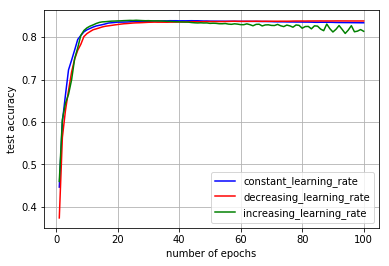

In [80]:
x=[i for i in range(1,101)]
plt.plot(x, test_acc_c , 'b', label='constant_learning_rate')
plt.plot(x,test_acc_d, 'r', label='decreasing_learning_rate')
plt.plot(x, test_acc_i, 'g', label='increasing_learning_rate')
plt.ylabel('test accuracy')
plt.xlabel('number of epochs')
plt.grid()
plt.legend() # add legend based on line labels
plt.show()